In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

DATADIR = r"/content/drive/MyDrive/data_im/imagenette2-160/train"

CATEGORIES = ["n01440764", "n02102040", "n02979186", "n03000684", "n03028079", "n03394916",
              "n03417042", "n03425413", "n03445777", "n03888257"]
dataset = list()
categories = list()
categories_name = list()
for category in CATEGORIES:  
    path = os.path.join(DATADIR,category) 
    for img in os.listdir(path):  
        img_array = cv2.imread(os.path.join(path,img))  
        dataset.append(img_array)
        if category=="n01440764":
            categories.append(0)
            categories_name.append(category)
        elif category=="n02102040":
            categories.append(1)
            categories_name.append(category)
        elif category=="n02979186":
            categories.append(2)
            categories_name.append(category)
        elif category=="n03000684":
            categories.append(3)
            categories_name.append(category)
        elif category=="n03028079":
            categories.append(4)
            categories_name.append(category)
        elif category=="n03394916":
            categories.append(5)
            categories_name.append(category)
        elif category=="n03417042":
            categories.append(6)
            categories_name.append(category)
        elif category=="n03425413":
            categories.append(7)
            categories_name.append(category)
        elif category=="n03445777":
            categories.append(8)
            categories_name.append(category)
        elif category=="n03888257":
            categories.append(9)
            categories_name.append(category)

In [ ]:
len(dataset)

9469

In [ ]:
categories = np.asarray(categories)
categories_name = np.asarray(categories_name)
categories_name

array(['n01440764', 'n01440764', 'n01440764', ..., 'n03888257',
       'n03888257', 'n03888257'], dtype='<U9')

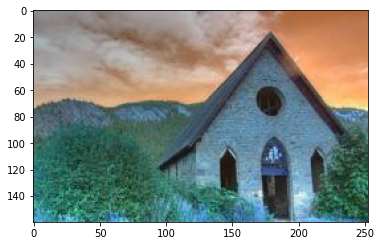

In [ ]:
plt.imshow(dataset[3800])

In [ ]:
import torch.utils.data as data

class ImageFileset(data.Dataset):
    def __init__(self, flist, transform=None):
        self.imlist = flist
        self.transform = transform

    def __getitem__(self, index):
        img = self.imlist[index]
        if self.transform is not None:
              img = self.transform(img)

        return img

    def __len__(self):
        return len(self.imlist)

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()])
    #transforms.Normalize((0.42983678, 0.39725652, 0.52416897), (0.28184757, 0.26598915, 0.34225056))])

trainset = ImageFileset(dataset,transform=transform)

train_dataset, validationset = torch.utils.data.random_split(trainset, [6628,2841])

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validationset,batch_size=32, shuffle=True)

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [ ]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [ ]:
image_channels = 3

In [ ]:
print(vae)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

epochs = 30

In [ ]:
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 3052291


In [ ]:
train_loss = []
val_loss = []
for epoch in range(epochs):
  
    running_loss_tr = 0
    running_loss_val = 0.0    
    vae.train()

    for idx, images in enumerate(train_loader):
        #images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_function(recon_images, images, mu, logvar)
        running_loss_tr += loss.item()
        loss.backward()
        optimizer.step()

    train_loss.append(running_loss_tr/len(train_loader.dataset))

    vae.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_loader): 
            #data, _ = data
            #data = data.to(device)
            #data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = vae(data)
            loss_val,  bce, kld = loss_function(reconstruction, data, mu, logvar)
            running_loss_val += loss_val.item()
      
          # save the last batch input and output of every epoch
            #if i == int(len(validationset)/validation_loader.batch_size) - 1:
                #num_rows = 8
                #both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                            #    reconstruction.view(batch_size, 1, 28, 28)[:8]))
              #save_image(both.cpu(), f'./data/output{epoch}.png', nrow=num_rows)

        val_loss.append(running_loss_val/len(validation_loader.dataset))

    print('====> Epoch: {} Train Average loss: {:.4f}'.format(epoch+1, running_loss_tr / len(train_loader.dataset)))
    print('====> Epoch: {} Val Average loss:   {:.4f}'.format(epoch+1, running_loss_val / len(validation_loader.dataset)))
    print('-'*50)

====> Epoch: 1 Train Average loss: 7687.5753
====> Epoch: 1 Val Average loss:   7336.6367
--------------------------------------------------
====> Epoch: 2 Train Average loss: 7211.2006
====> Epoch: 2 Val Average loss:   7195.4906
--------------------------------------------------
====> Epoch: 3 Train Average loss: 7113.3622
====> Epoch: 3 Val Average loss:   7147.0325
--------------------------------------------------
====> Epoch: 4 Train Average loss: 7056.5135
====> Epoch: 4 Val Average loss:   7130.3611
--------------------------------------------------
====> Epoch: 5 Train Average loss: 7016.1802
====> Epoch: 5 Val Average loss:   7097.7245
--------------------------------------------------
====> Epoch: 6 Train Average loss: 6942.8677
====> Epoch: 6 Val Average loss:   7026.7237
--------------------------------------------------
====> Epoch: 7 Train Average loss: 6902.9138
====> Epoch: 7 Val Average loss:   6957.4561
--------------------------------------------------
====> Epoch: 

In [ ]:
PATH = './Imagenette_VAE_30ep_conv.pth'
torch.save(vae.state_dict(), PATH)

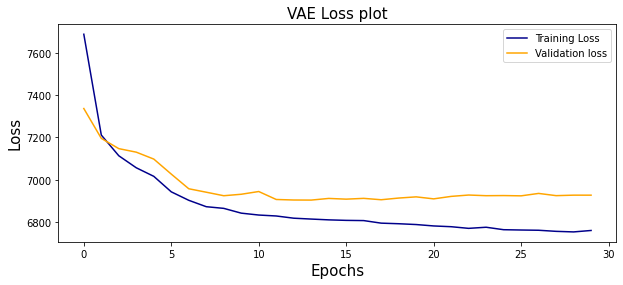

In [ ]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,4))
epochs_plot = np.arange(0,30)
plt.plot(epochs_plot, train_loss, label = "Training Loss", color="darkblue")
plt.plot(epochs_plot, val_loss , label = "Validation loss", color = "orange")
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.title("VAE Loss plot", fontsize=15)
plt.legend()
#plt.savefig('VAE_Loss_plot_Imagenette.svg')
plt.show()

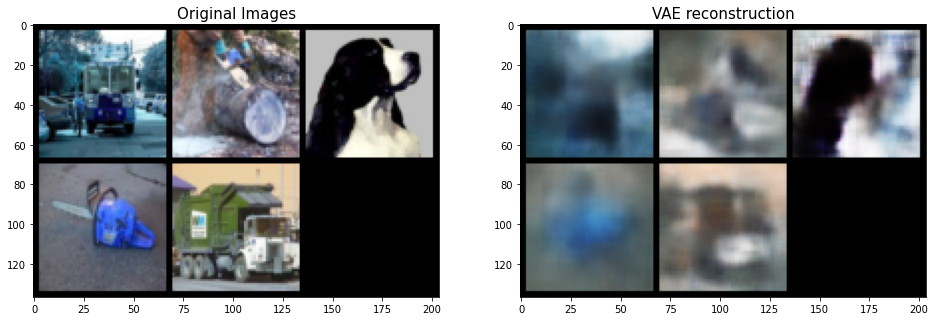

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils
plt.figure(figsize=(16,8))
vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images = iter(validation_loader).next()

# First visualise the original images
plt.subplot(1, 2, 1)
plt.title('Original Images', fontsize = 15)
x = torchvision.utils.make_grid(images[1:6],3,3)
x = x.clamp(0,1)
x = x.numpy()
plt.imshow(np.transpose(x,(1,2,0) ))


# Reconstruct and visualise the images using the vae
plt.subplot(1, 2, 2)
plt.title('VAE reconstruction', fontsize = 15)
with torch.no_grad():
    #images_recon = images.to(device)
    #images_recon = images_recon.view(images_recon.size(0), -1)
    images_recon, _, _ = vae(images)
    images_recon = images_recon.cpu()
    images_recon = images_recon.view(32, 3, 64, 64)
    np_imagegrid = torchvision.utils.make_grid(images_recon[1:6], 3, 3).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

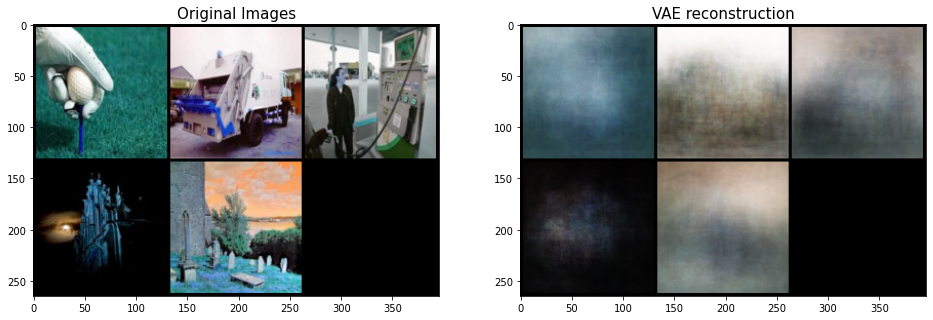

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils
plt.figure(figsize=(16,8))
vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images = iter(validation_loader).next()

# First visualise the original images
plt.subplot(1, 2, 1)
plt.title('Original Images', fontsize = 15)
x = torchvision.utils.make_grid(images[1:6],3,3)
x = x.clamp(0,1)
x = x.numpy()
plt.imshow(np.transpose(x,(1,2,0) ))


# Reconstruct and visualise the images using the vae
plt.subplot(1, 2, 2)
plt.title('VAE reconstruction', fontsize = 15)
with torch.no_grad():
    images_recon = images.to(device)
    images_recon = images_recon.view(images_recon.size(0), -1)
    images_recon, _, _ = vae(images_recon)
    images_recon = images_recon.cpu()
    images_recon = images_recon.view(batch_size, 3, 128, 128)
    np_imagegrid = torchvision.utils.make_grid(images_recon[1:6], 3, 3).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()